# Discontinuous Conversion Laws

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import scipy
import time
import os
import time
import matplotlib.animation
from scipy.optimize import fsolve
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.utils.tensorboard import SummaryWriter
from utilities import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def solve_w(x, t, w0):
    func = lambda w: w - np.sin(x - (w + 0.5) * t)
    w_solution = fsolve(func, w0)
    return w_solution[0] 

def burgers_exact_scalar(x, t):
    left = solve_w(x, t, 0.8) + 0.5
    right = solve_w(x, t, -0.8) + 0.5
    if x <= 0.5 * t + np.pi:
        return left
    elif x >= 0.5 * t + np.pi:
        return right
    else:
        return (left + right)/2

burgers_exact = np.vectorize(burgers_exact_scalar)

In [17]:
# x = np.linspace(0, 2*np.pi, 5000)
# t = np.linspace(0, 1.5, 1000)
# xx, tt = np.meshgrid(x, t)
# xx = xx.flatten()
# tt = tt.flatten()
# u_exact = burgers_exact(xx, tt)
# np.save("burgers_exact.npy", u_exact)

# fig = plt.figure(figsize=(8,4))
# ax = fig.add_subplot(111)
# # pic = ax.tricontourf(xt[:,0], xt[:,1], u, levels=100, cmap='jet')
# pic = ax.tricontourf(xx, tt, u_exact, levels=100, cmap='jet')
# fig.colorbar(pic, ax=ax)
# # ax.set_aspect('equal')
# ax.set_xlabel('x')
# ax.set_ylabel('t')

In [38]:
u_exact = np.load("burgers_exact.npy")

In [72]:
class Burgers:
    def __init__(self, N_x:int, N_t:int, Nint_x:int, deg:int, num_layers:int=2, hidden_size:int=20, act:str='tanh') -> None:
        #
        self.name = f'DG_burgers_{N_x}_{N_t}_{Nint_x}_{deg}_{num_layers}_{hidden_size}_{act}'
        self.np_dtype = np.float64
        self.torch_dtype = torch.float64
        self.save_path = f'./models/DGNet/{self.name}.pth'
        #
        self.a = 0.0
        self.b = 2.0 * pi
        self.t0 = 0.0
        self.T = 1.5
        #
        self.N_x = N_x
        self.N_t = N_t
        self.Nint_x = Nint_x
        self.deg = deg
        #
        self.testfunc = TestFunction1D(func_type='Polynomial')
        #
        self.x, self.xc, self.h, self.t, self.Mesh, self.xmesh, self.weights = self.get_mesh()
        self.v, self.dv = self.test_data()
        self.model = DGNet(num_modules=self.N_x, input_size=2, hidden_size=hidden_size, output_size=1, num_layers=num_layers, act=act).to(device).to(self.torch_dtype)
        mesh = self.Mesh.cpu().detach().numpy()
        self.u_exact = torch.tensor(burgers_exact(mesh[:, :, :, 0], mesh[:, :, :, 1])).to(device)
        #
        self.f = lambda x: x ** 2 / 2
        self.init = lambda x: torch.sin(x) + 1/2
        self.flux = lambda x, y: x - y
        self.exact_init = self.init(self.xmesh)
        #
        self.Lfbgs = torch.optim.LBFGS(self.model.parameters(), lr=1.0, max_iter=20000, 
                                           max_eval=50000, history_size=50, tolerance_grad=1e-7, 
                                           tolerance_change=1.0 * np.finfo(float).eps, 
                                           line_search_fn='strong_wolfe')
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-4); self.maxiter = 10000; self.adamiter = 0
        self.iter = 0
      

    def test_data(self):
        v_list = []
        dv_list = []
        for i in range(self.deg + 1):
            v, dv = self.testfunc.get_value(x=self.xmesh, x_mid=self.xc[:, None], h=self.h[:, None], order=i)
            v_list.append(v)
            dv_list.append(dv)
        v = torch.stack(v_list, dim=0).to(device)
        dv = torch.stack(dv_list, dim=0).to(device)
        return v, dv
    
    def get_mesh(self):
        #
        x = np.linspace(self.a, self.b, self.N_x + 1)
        t = np.linspace(self.t0, self.T, self.N_t + 1)
        xc = (x[:-1] + x[1:]) / 2.0
        h = (x[1:] - x[:-1]) 
        nodes, weights = np.polynomial.legendre.leggauss(self.Nint_x)
        #
        mesh = 0.5 * (nodes[None, :] + 1) * h[:, None] + x[:-1, None]
        weights = 0.5 * weights[None, :] * h[:, None]
        xmesh = np.zeros((self.N_x, self.Nint_x + 2))
        xmesh[:, 1:-1] = mesh
        xmesh[:, 0] = x[:-1]
        xmesh[:, -1] = x[1:]
        Mesh = []
        for i in range(self.N_x):
            xx, tt = np.meshgrid(xmesh[i, :], t)
            Mesh.append(np.stack([xx, tt], axis=-1))
        Mesh = np.array(Mesh)
        return torch.tensor(x, dtype=self.torch_dtype).to(device), \
               torch.tensor(xc, dtype=self.torch_dtype).to(device), \
               torch.tensor(h, dtype=self.torch_dtype).to(device),\
               torch.tensor(t, dtype=self.torch_dtype).to(device),\
               torch.tensor(Mesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(xmesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(weights, dtype=self.torch_dtype).to(device)

    
    def loss(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        fu = self.f(u)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux = gradu[..., 0]; ut = gradu[..., 1]
        #
        lfu = self.f(u[:, :, 0, 0]); rfu = self.f(u[:, :, -1, 0])
        lv = self.v[:, :, 0]; rv = self.v[:, :, -1]
        bd = rfu[None, ...] * rv[:, :, None] - lfu[None, ...] * lv[:, :, None]
        #
        flux_u = self.flux(u[:-1, :, -1, 0], u[1:, :, 0, 0])
        # flux_ux = self.flux(ux[:-1, :, -1], ux[1:, :, 0]) 
        lux = ux[0, :, 0]; rux = ux[-1, :, -1]
        ux = ux[:, :, 1:-1]; ut = ut[:, :, 1:-1]
        

        # compute local loss
        Int = torch.sum((ut[None, ...] * self.v[:, :, None, 1:-1] - fu[None, :, :, 1:-1, 0] * self.dv[:, :, None, 1:-1]) * self.weights[None, :, None, :], dim=-1) + bd
        local_loss = torch.sum(Int**2)
        # compute init_loss
        init_loss = torch.sum((u[:, 0, :, 0] - self.exact_init)**2)
        # compute bd_loss
        bd_loss = torch.sum((u[0, :, 0, 0] - u[-1, :, -1, 0])**2 + (rux - lux)**2)
        # compute flux_loss
        flux_loss = torch.sum(flux_u**2)
        loss = local_loss + init_loss + bd_loss + flux_loss
        mse = torch.mean((u.squeeze(-1)-self.u_exact)**2)
        mae = torch.max(torch.abs(u.squeeze(-1)-self.u_exact))
        return loss, mse, mae
    
    def loss_lfbgs(self):
        self.Lfbgs.zero_grad()
        loss, mse, mae = self.loss()
        loss.backward()
        self.writer.add_scalar(f"mse_vs_iter", mse, self.iter + self.adamiter)
        self.writer.add_scalar(f"mse_vs_time", mse, time.time() - self.t)
        self.iter += 1
        if self.iter % 100 == 0:
            print(f"LBFGS At iter: {self.iter}, loss_train:{loss.item():.6f}, mse:{mse.item():.6f}, mae:{mae.item():.6f}")
        return loss
    
    def loss_adam(self):
        self.Adam.zero_grad()
        loss, mse, mae = self.loss()
        self.writer.add_scalar(f"mse_vs_iter", mse, self.iter + self.adamiter)
        self.writer.add_scalar(f"mse_vs_time", mse, time.time() - self.t)
        self.adamiter += 1
        if self.adamiter % 100 == 0:
            print(f"Adam At iter: {self.adamiter}, loss_train:{loss.item():.6f}, mse:{mse.item():.6f}, mae:{mae.item():.6f}")
        return loss
    def train(self):
        t_start = time.time()
        print('*********** Started training ...... ***************')
        self.writer = SummaryWriter(f'logs/burgers1d/DGNet')
        self.t = time.time()
        self.Lfbgs.step(self.loss_lfbgs)
        torch.save(self.model.state_dict(), self.save_path)
        loss = self.loss_adam()
        best_loss = loss
        while loss > 1e-3:
            loss.backward()
            self.Adam.step()
            loss = self.loss_adam()
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), self.save_path)
            if self.adamiter > self.maxiter:
                break
        self.adamiter = 0
        self.writer.close()
        print(f'Finished training in {time.time()-t_start:.4f} seconds')
    def load(self):
        if os.path.exists(self.save_path):
            print("Loading saved model...")
            model_dict = torch.load(self.save_path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train...")
            return False

class Burgers_pinn():
    def __init__(self, method:str='PINN', num_layers:int=4, hidden_size:int=128, act:str='tanh') -> None:
        self.name = f'1dburgers_{method}_{num_layers}_{hidden_size}_{act}'
        self.method = method
        self.torch_dtype = torch.float64
        x = np.linspace(0, 2*np.pi, 1000)
        t = np.linspace(0, 1.5, 100)
        xx, tt = np.meshgrid(x, t)
        self.mesh = np.stack([xx, tt], axis=-1)
        self.model = MLP(input_size=2, output_size=1, hidden_size=hidden_size, num_layers=num_layers, act=act).to(device)
        self.init = lambda x: torch.sin(x) + 1/2
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.maxiter = 40000
        self.u_exact = torch.tensor(burgers_exact(self.mesh[:,:, 0], self.mesh[:,:, 1])).to(device)

    def loss(self):
        if self.method == 'PINN':
            return self.pinn()
        else:
            pass
        
    def pinn(self):
        mesh = torch.tensor(self.mesh, dtype=torch.float32, requires_grad=True).to(device)
        u = self.model(mesh)
        grad_u = torch.autograd.grad(u, mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux = grad_u[..., 0]; ut = grad_u[..., 1]
        eq_loss = torch.sum((ut+u.squeeze(-1)*ux)**2)
        init_loss = torch.sum((self.init(mesh[0, :, 0])-u[0, :, 0])**2)
        bd_loss = torch.sum((u[:, 0, 0]-u[:, -1, 0])**2) + torch.sum((ux[0, :]-ux[-1, :])**2)
        loss =  eq_loss + init_loss + bd_loss
        mse = torch.mean((u.squeeze(-1)-self.u_exact)**2)
        mae = torch.max(torch.abs(u.squeeze(-1)-self.u_exact))
        return loss, mse, mae


    def train(self):
        print('*********** Started training ...... ***************')
        t = time.time()
        self.writer = SummaryWriter(f'./logs/burgers1d/PINN')
        loss, mse, mae = self.loss()
        best_loss = loss
        epoch = 0
        while  epoch < self.maxiter:
            self.Adam.zero_grad()
            loss, mse, mae = self.loss()
            self.writer.add_scalar(f"mse_vs_iter", mse, epoch)
            self.writer.add_scalar(f"mse_vs_time", mse, time.time() - t)
            loss.backward()
            self.Adam.step()
            epoch += 1
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), f'./models/PINN/{self.name}.pth')
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}, mse = {mse.item():.6f}, mae = {mae.item():.6f}")
        self.writer.close()
        print(f'Finished training in {time.time()-t:.4f} seconds')
    def load(self):
        path = f'./models/{self.method}/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train")
            return False
    
class Burgers_hpVPINN:
    def __init__(self, N_x:int, N_t:int, Nint_x:int, deg:int, num_layers:int=2, hidden_size:int=20, act:str='tanh') -> None:
        #
        self.name = f'1dburgers_{N_x}_{N_t}_{Nint_x}_{deg}_{num_layers}_{hidden_size}_{act}'
        self.np_dtype = np.float64
        self.torch_dtype = torch.float64
        self.save_path = f'./models/DGNet/{self.name}.pth'
        #
        self.a = 0.0
        self.b = 2.0 * pi
        self.t0 = 0.0
        self.T = 1.5
        #
        self.N_x = N_x
        self.N_t = N_t
        self.Nint_x = Nint_x
        self.deg = deg
        #
        self.testfunc = TestFunction1D(func_type='Legendre')
        #
        self.x, self.xc, self.h, self.t, self.Mesh, self.xmesh, self.weights = self.get_mesh()
        mesh = self.Mesh.cpu().detach().numpy()
        self.v, self.dv = self.test_data()
        self.model = MLP(input_size=2, hidden_size=hidden_size, output_size=1, num_layers=num_layers, act=act).to(device).to(self.torch_dtype)
        #
        self.f = lambda x: x ** 2 / 2
        self.init = lambda x: torch.sin(x) + 1/2
        self.exact_init = self.init(self.xmesh)
        self.u_exact = torch.tensor(burgers_exact(mesh[:,:, :, 0], mesh[:,:, :, 1])).to(device)
        #
        self.Lfbgs = torch.optim.LBFGS(self.model.parameters(), lr=1.0, max_iter=40000, 
                                           max_eval=50000, history_size=50, tolerance_grad=1e-7, 
                                           tolerance_change=1.0 * np.finfo(float).eps, 
                                           line_search_fn='strong_wolfe')
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-4); self.maxiter = 70000; self.adamiter = 0
        self.iter = 0
      

    def test_data(self):
        v_list = []
        dv_list = []
        for i in range(self.deg + 1):
            v, dv = self.testfunc.get_value(x=self.xmesh, x_mid=self.xc[:, None], h=self.h[:, None], order=i)
            v_list.append(v)
            dv_list.append(dv)
        v = torch.stack(v_list, dim=0).to(device)
        dv = torch.stack(dv_list, dim=0).to(device)
        return v, dv
    
    def get_mesh(self):
        #
        x = np.linspace(self.a, self.b, self.N_x + 1)
        t = np.linspace(self.t0, self.T, self.N_t + 1)
        xc = (x[:-1] + x[1:]) / 2.0
        h = (x[1:] - x[:-1]) 
        nodes, weights = np.polynomial.legendre.leggauss(self.Nint_x)
        #
        mesh = 0.5 * (nodes[None, :] + 1) * h[:, None] + x[:-1, None]
        weights = 0.5 * weights[None, :] * h[:, None]
        xmesh = np.zeros((self.N_x, self.Nint_x + 2))
        xmesh[:, 1:-1] = mesh
        xmesh[:, 0] = x[:-1]
        xmesh[:, -1] = x[1:]
        Mesh = []
        for i in range(self.N_x):
            xx, tt = np.meshgrid(xmesh[i, :], t)
            Mesh.append(np.stack([xx, tt], axis=-1))
        Mesh = np.array(Mesh)
        return torch.tensor(x, dtype=self.torch_dtype).to(device), \
               torch.tensor(xc, dtype=self.torch_dtype).to(device), \
               torch.tensor(h, dtype=self.torch_dtype).to(device),\
               torch.tensor(t, dtype=self.torch_dtype).to(device),\
               torch.tensor(Mesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(xmesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(weights, dtype=self.torch_dtype).to(device)

    
    def loss(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        fu = self.f(u)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux = gradu[..., 0]; ut = gradu[..., 1]
        #
        lfu = self.f(u[:, :, 0, 0]); rfu = self.f(u[:, :, -1, 0])
        lv = self.v[:, :, 0]; rv = self.v[:, :, -1]
        bd = rfu[None, ...] * rv[:, :, None] - lfu[None, ...] * lv[:, :, None]
        #
        lux = ux[0, :, 0]; rux = ux[-1, :, -1]
        ux = ux[:, :, 1:-1]; ut = ut[:, :, 1:-1]
        

        # compute local loss
        Int = torch.sum((ut[None, ...] * self.v[:, :, None, 1:-1] - fu[None, :, :, 1:-1, 0] * self.dv[:, :, None, 1:-1]) * self.weights[None, :, None, :], dim=-1) + bd
        local_loss = torch.sum(Int**2)
        # compute init_loss
        init_loss = torch.sum((u[:, 0, :, 0] - self.exact_init)**2)
        # compute bd_loss
        bd_loss = torch.sum((u[0, :, 0, 0] - u[-1, :, -1, 0])**2 + (rux - lux)**2)
        # compute flux_loss
        loss = local_loss + init_loss + bd_loss
        mse = torch.mean((u.squeeze(-1)-self.u_exact)**2)
        mae = torch.max(torch.abs(u.squeeze(-1)-self.u_exact))
        return loss, mse, mae

    def train(self):
        print('*********** Started training ...... ***************')
        t = time.time()
        self.writer = SummaryWriter(f'./logs/burgers1d/hpVPINN')
        loss, mse, mae = self.loss()
        best_loss = loss
        epoch = 0
        while  epoch < self.maxiter:
            self.Adam.zero_grad()
            loss, mse, mae = self.loss()
            self.writer.add_scalar(f"mse_vs_iter", mse, epoch)
            self.writer.add_scalar(f"mse_vs_time", mse, time.time() - t)
            loss.backward()
            self.Adam.step()
            epoch += 1
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), f'./models/hpVPINN/{self.name}.pth')
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}, mse = {mse.item():.6f}, mae = {mae.item():.6f}")
        self.writer.close()
        print(f'Finished training in {time.time()-t:.4f} seconds')
    def load(self):
        path = f'./models/hpVPINN/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train")
            return False
 

In [36]:
B_dg = Burgers(N_x=11, N_t=30, Nint_x=30, deg=3, num_layers=2, hidden_size=50, act='tanh')
# B.loss()
# retrain = True
# if B.load() and not retrain:
#     print("train loss: ", B.loss())
# elif retrain:
#     # B.load()
#     B.train()
# B.train()
B_dg.load()
model = B_dg.model
xt = B_dg.Mesh[:, :, :, :]
u_dg = model(xt).squeeze(-1)
u_dg_exact = B_dg.u_exact.squeeze(-1)
xt_dg = xt.detach().cpu().numpy().reshape(-1, 2)
u_dg = u_dg.detach().cpu().numpy().flatten()
u_dg_exact = u_dg_exact.detach().cpu().numpy().flatten()

/tmp/ipykernel_14701/307322008.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  w_solution = fsolve(func, w0)
/tmp/ipykernel_14701/307322008.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  w_solution = fsolve(func, w0)


Loading saved model...


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [63]:
B_pinn = Burgers_pinn(method='PINN')
B_pinn.train()
B_pinn.load()
xt_pinn = B_pinn.mesh.reshape(-1, 2)
u_pinn_exact = B_pinn.u_exact.reshape(-1).detach().cpu().numpy()
u_pinn = B_pinn.model(torch.tensor(xt_pinn, dtype=torch.float32).to(device)).detach().cpu().numpy().flatten()


/tmp/ipykernel_14701/1575900719.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  w_solution = fsolve(func, w0)
/tmp/ipykernel_14701/1575900719.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  w_solution = fsolve(func, w0)


*********** Started training ...... ***************


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 100: Loss = 307.070129, mse = 0.281940, mae = 1.026120
Epoch 200: Loss = 280.602936, mse = 0.252793, mae = 1.020764
Epoch 300: Loss = 260.259430, mse = 0.222602, mae = 1.041224
Epoch 400: Loss = 251.427917, mse = 0.210393, mae = 1.043374
Epoch 500: Loss = 248.254059, mse = 0.204997, mae = 1.019481
Epoch 600: Loss = 241.410324, mse = 0.198254, mae = 1.025017
Epoch 700: Loss = 235.929947, mse = 0.192253, mae = 1.009773
Epoch 800: Loss = 228.916138, mse = 0.185115, mae = 1.003404
Epoch 900: Loss = 223.859558, mse = 0.177762, mae = 1.008070
Epoch 1000: Loss = 216.318069, mse = 0.172664, mae = 1.015638
Epoch 1100: Loss = 211.630447, mse = 0.167685, mae = 1.023233
Epoch 1200: Loss = 209.124329, mse = 0.164584, mae = 1.034947
Epoch 1300: Loss = 217.569473, mse = 0.163090, mae = 1.003949
Epoch 1400: Loss = 202.551346, mse = 0.159266, mae = 1.015921
Epoch 1500: Loss = 201.108307, mse = 0.158404, mae = 1.014789
Epoch 1600: Loss = 200.930817, mse = 0.160592, mae = 1.020975
Epoch 1700: Loss 

In [73]:
B_hpVPINN = Burgers_hpVPINN(N_x=3, N_t=100, Nint_x=40, deg=10, num_layers=3, hidden_size=128, act='tanh')
B_hpVPINN.train()
model = B_hpVPINN.model
B_hpVPINN.load()
xt = B_hpVPINN.Mesh[:, :, :, :]
u_hpVPINN = model(xt).squeeze(-1)
u_hpVPINN_exact = B_hpVPINN.u_exact.squeeze(-1)

xt_hpVPINN = xt.detach().cpu().numpy().reshape(-1, 2)
u_hpVPINN = u_hpVPINN.detach().cpu().numpy().flatten()
u_hpVPINN_exact = u_hpVPINN_exact.detach().cpu().numpy().flatten()


/tmp/ipykernel_14701/1575900719.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  w_solution = fsolve(func, w0)
/tmp/ipykernel_14701/1575900719.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  w_solution = fsolve(func, w0)


*********** Started training ...... ***************
Epoch 100: Loss = 53.241673, mse = 0.407469, mae = 1.010711
Epoch 200: Loss = 41.251460, mse = 0.329774, mae = 1.001953
Epoch 300: Loss = 25.029393, mse = 0.191284, mae = 1.044178
Epoch 400: Loss = 20.763367, mse = 0.157374, mae = 0.997192
Epoch 500: Loss = 18.639079, mse = 0.139799, mae = 0.997177
Epoch 600: Loss = 16.528395, mse = 0.124549, mae = 0.996929
Epoch 700: Loss = 14.516233, mse = 0.107918, mae = 0.996190
Epoch 800: Loss = 13.206158, mse = 0.094376, mae = 1.014028
Epoch 900: Loss = 12.447041, mse = 0.086255, mae = 1.029371
Epoch 1000: Loss = 11.935145, mse = 0.081044, mae = 1.043521
Epoch 1100: Loss = 11.545551, mse = 0.077572, mae = 1.054231
Epoch 1200: Loss = 11.209536, mse = 0.074928, mae = 1.061883
Epoch 1300: Loss = 11.011037, mse = 0.073869, mae = 1.054671
Epoch 1400: Loss = 10.675541, mse = 0.070280, mae = 1.078987
Epoch 1500: Loss = 10.452775, mse = 0.068237, mae = 1.085841
Epoch 1600: Loss = 10.307122, mse = 0.0658

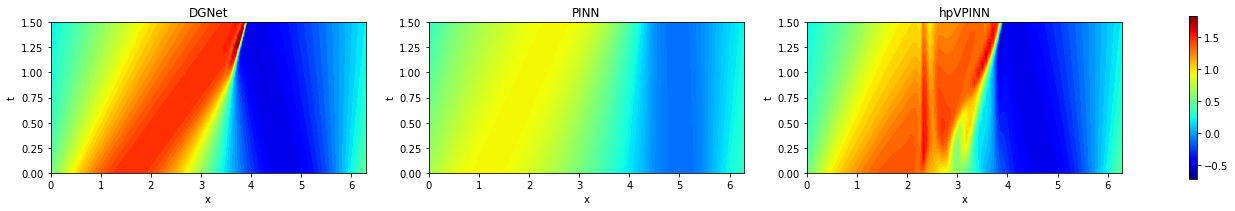

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(24, 3))
vmin = min(u_exact.min(), u_dg.min(), u_pinn.min(), u_hpVPINN.min())
vmax = max(u_exact.max(), u_dg.max(), u_pinn.max(), u_hpVPINN.max())

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("jet")

a = axes[0].tricontourf(xt_dg[:, 0], xt_dg[:, 1], u_dg, levels=50, cmap=cmap, norm=norm)
b = axes[1].tricontourf(xt_pinn[:, 0], xt_pinn[:, 1], u_pinn, levels=50, cmap=cmap, norm=norm)
c = axes[2].tricontourf(xt_hpVPINN[:, 0], xt_hpVPINN[:, 1], u_hpVPINN, levels=50, cmap=cmap, norm=norm)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical')

axes[0].set_title("DGNet")
axes[1].set_title("PINN")
axes[2].set_title("hpVPINN")
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[0].set_aspect(2)
axes[1].set_aspect(2)
axes[2].set_aspect(2)

plt.show()

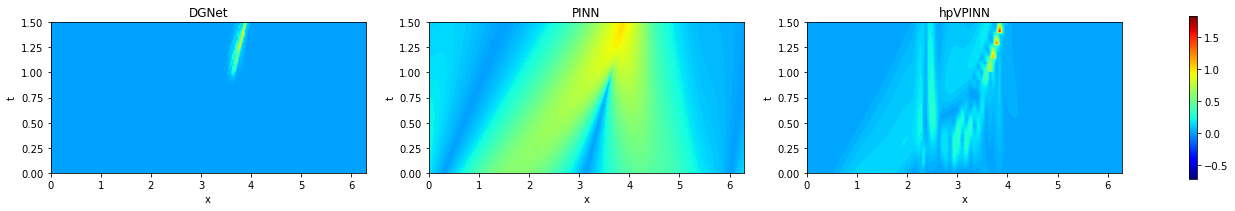

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(24, 3))
a = axes[0].tricontourf(xt_dg[:, 0], xt_dg[:, 1], abs(u_dg-u_dg_exact), levels=50, cmap=cmap, norm=norm)
b = axes[1].tricontourf(xt_pinn[:, 0], xt_pinn[:, 1], abs(u_pinn-u_pinn_exact), levels=50, cmap=cmap, norm=norm)
c = axes[2].tricontourf(xt_hpVPINN[:, 0], xt_hpVPINN[:, 1], abs(u_hpVPINN-u_hpVPINN_exact), levels=50, cmap=cmap, norm=norm)


cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical')

axes[0].set_title("DGNet")
axes[1].set_title("PINN")
axes[2].set_title("hpVPINN")
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[0].set_aspect(2)
axes[1].set_aspect(2)
axes[2].set_aspect(2)

plt.show()

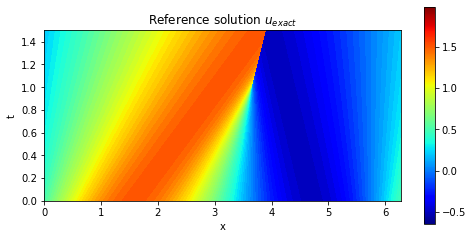

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
x = np.linspace(0, 2*np.pi, 5000)
t = np.linspace(0, 1.5, 1000)
xx, tt = np.meshgrid(x, t)
xx = xx.flatten()
tt = tt.flatten()

# 绘制等高填充图
pic = ax.tricontourf(xx, tt, u_exact, levels=50, cmap=cmap, norm=norm)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', aspect=20)

# 设置标题
ax.set_title("Reference solution $u_{exact}$")
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_aspect(2)

plt.show()

# End

Loading saved model...
(tensor(1.6948e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>), tensor(0.0007, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(1.0065, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>))


Text(0, 0.5, 't')

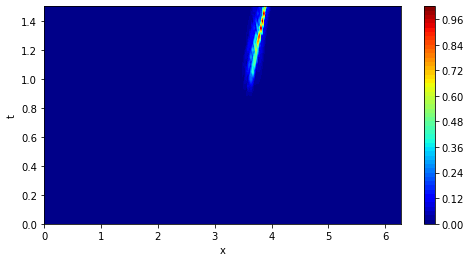

In [21]:
model = B_dg.model
path = f'./models/DGNet/{B_dg.name}.pth'
B_dg.load()
print(B_dg.loss())
u_exact = B_dg.u_exact
xt = B_dg.Mesh[:, :, :, :]
u = model(xt).squeeze(-1)

xt = xt.detach().cpu().numpy().reshape(-1, 2)
u = u.detach().cpu().numpy().flatten()
u_exact = u_exact.detach().cpu().numpy().flatten()

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
pic = ax.tricontourf(xt[:,0], xt[:,1], abs(u-u_exact), levels=50, cmap='jet')
# pic = ax.tricontourf(xt[:,0], xt[:,1], u_exact, levels=100, cmap='jet')
fig.colorbar(pic, ax=ax)
# ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('t')



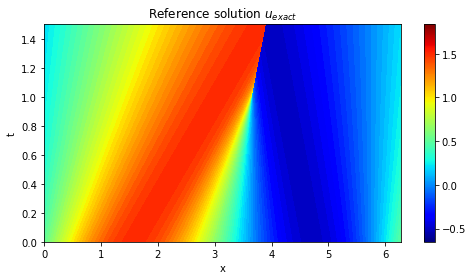

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))  # 只创建一个子图
vmin = min(u_exact.min(), u.min())
vmax = max(u_exact.max(), u.max())

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("jet")
x = np.linspace(0, 2*np.pi, 5000)
t = np.linspace(0, 1.5, 1000)
xx, tt = np.meshgrid(x, t)
xx = xx.flatten()
tt = tt.flatten()

# 绘制等高填充图
pic = ax.tricontourf(xx, tt, u_exact, levels=50, cmap=cmap, norm=norm)

# 添加颜色条
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical')

# 设置标题
ax.set_title("Reference solution $u_{exact}$")
ax.set_xlabel('x')
ax.set_ylabel('t')

plt.show()


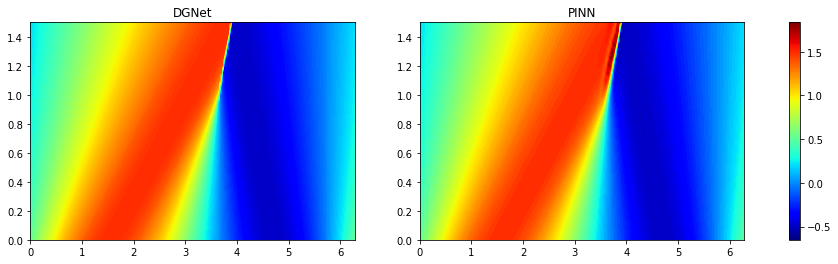

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
vmin = min(u_exact.min(), u.min())
vmax = max(u_exact.max(), u.max())

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("jet")

#
a = axes[0].tricontourf(xt[:,0], xt[:,1], u_exact, levels=100, cmap=cmap, norm=norm)
b = axes[1].tricontourf(xt[:,0], xt[:,1], u, levels=100, cmap=cmap, norm=norm)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical')
# axes[0].axis('equal')
# axes[1].axis('equal')

# 设置标题
axes[0].set_title("DGNet")
axes[1].set_title("PINN")
# fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
plt.show()

In [22]:

# xt = B.Mesh[:, :, :, :]
# u = model(xt)[:, :, :, 0]
# u = u.detach().cpu().numpy()
# xt = xt.detach().cpu().numpy()
# x0 = xt[:, 0, :, 0].reshape(-1,)


# # xt = B.Mesh[:, :, :, :].reshape(-1, 2)
# # xt = xt.detach().cpu().numpy()
# # xx, tt = xt[:, 0], xt[:, 1]
# u_exact = burgers_exact(xt[:,:,:, 0], xt[:,:,:,1])

# fig, ax = plt.subplots(figsize=(5,5))
# def animate(t):
#     y = u[:, t, :].flatten()
#     y_exact = u_exact[:, t, :].flatten()
#     plt.cla()
#     plt.plot(x0, abs(y-y_exact))
#     # plt.plot(x0, y_exact)
#     # plt.plot(x0, y)
# # for x in x0:
# #     plt.axvline(x, color='gray', alpha=0.3)
# ani = matplotlib.animation.FuncAnimation(fig, animate, frames=30)
# ani.save(f'./{B.name}.gif', fps=5)

In [23]:

# # 生成网格
# # x = np.linspace(0, 2*np.pi, 1000)
# # t = np.linspace(0, 1.5, 100)
# # xx, tt = np.meshgrid(x, t)
# # u_exact = exact(xx, tt)
# #

# xt = B.Mesh[:, :, :, :].reshape(-1, 2)
# xt = xt.detach().cpu().numpy()
# xx, tt = xt[:, 0], xt[:, 1]
# u_exact = burgers_exact(xx, tt)
# u = u.reshape(-1)
# # 绘图
# fig, ax = plt.subplots(figsize=(6, 5))
# # c = ax.contourf(xx, tt, u_exact, levels=100, cmap='jet')
# c = ax.tricontourf(xx, tt, abs(u-u_exact), levels=100, cmap='jet')
# plt.colorbar(c, ax=ax, label='u_exact')
# ax.set_xlabel('x')
# ax.set_ylabel('t')
# ax.set_title('Contour plot of u_exact')
# # ax.set_aspect('equal')
# plt.show()


## test baselines


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import scipy
import time
import os
from torch.utils.tensorboard import SummaryWriter
import matplotlib.animation
from scipy.optimize import fsolve
from utilities import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def solve_w(x, t, w0):
    func = lambda w: w - np.sin(x - (w + 0.5) * t)
    w_solution = fsolve(func, w0)
    return w_solution[0] 

vectorized_solve_w = np.vectorize(solve_w)
def burgers_exact(x, t):
    w1 = vectorized_solve_w(x, t, 0.8) + 0.5  
    w2 = vectorized_solve_w(x, t, -0.8) + 0.5 
    return np.where(x < 0.5*t + pi, w1, w2)

In [24]:
class Burgers_pinn():
    def __init__(self, method:str='PINN', num_layers:int=4, hidden_size:int=128, act:str='tanh') -> None:
        self.name = f'1dburgers_{method}_{num_layers}_{hidden_size}_{act}'
        self.method = method
        self.torch_dtype = torch.float64
        x = np.linspace(0, 2*np.pi, 1000)
        t = np.linspace(0, 1.5, 100)
        xx, tt = np.meshgrid(x, t)
        self.mesh = np.stack([xx, tt], axis=-1)
        self.model = MLP(input_size=2, output_size=1, hidden_size=hidden_size, num_layers=num_layers, act=act).to(device)
        self.init = lambda x: torch.sin(x) + 1/2
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.maxiter = 40000
        self.u_exact = torch.tensor(burgers_exact(self.mesh[:,:, 0], self.mesh[:,:, 1])).to(device)

    def loss(self):
        if self.method == 'PINN':
            return self.pinn()
        else:
            pass
        
    def pinn(self):
        mesh = torch.tensor(self.mesh, dtype=torch.float32, requires_grad=True).to(device)
        u = self.model(mesh)
        grad_u = torch.autograd.grad(u, mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux = grad_u[..., 0]; ut = grad_u[..., 1]
        eq_loss = torch.sum((ut+u.squeeze(-1)*ux)**2)
        init_loss = torch.sum((self.init(mesh[0, :, 0])-u[0, :, 0])**2)
        bd_loss = torch.sum((u[:, 0, 0]-u[:, -1, 0])**2) + torch.sum((ux[0, :]-ux[-1, :])**2)
        loss =  eq_loss + init_loss + bd_loss
        mse = torch.mean((u.squeeze(-1)-self.u_exact)**2)
        mae = torch.max(torch.abs(u.squeeze(-1)-self.u_exact))
        return loss, mse, mae


    def train(self):
        print('*********** Started training ...... ***************')
        t = time.time()
        self.writer = SummaryWriter(f'./logs/burgers1d/PINN')
        loss, mse, mae = self.loss()
        best_loss = loss
        epoch = 0
        while  epoch < self.maxiter:
            self.Adam.zero_grad()
            loss, mse, mae = self.loss()
            self.writer.add_scalar(f"mse_vs_iter", mse, epoch)
            self.writer.add_scalar(f"mse_vs_time", mse, time.time() - t)
            loss.backward()
            self.Adam.step()
            epoch += 1
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), f'./models/PINN/{self.name}.pth')
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}, mse = {mse.item():.6f}, mae = {mae.item():.6f}")
        self.writer.close()
        print(f'Finished training in {time.time()-t:.4f} seconds')
    def load(self):
        path = f'./models/{self.method}/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train")
            return False
    



In [25]:
B_pinn = Burgers1d(method='PINN')
B_pinn.train()

/tmp/ipykernel_32151/1119745042.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  w_solution = fsolve(func, w0)
/tmp/ipykernel_32151/1119745042.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  w_solution = fsolve(func, w0)


*********** Started training ...... ***************
Epoch 100: Loss = 281.690796, mse = 0.250854, mae = 1.030680
Epoch 200: Loss = 288.000549, mse = 0.219005, mae = 1.015373
Epoch 300: Loss = 243.514435, mse = 0.203966, mae = 1.012924
Epoch 400: Loss = 224.485016, mse = 0.181763, mae = 0.999872
Epoch 500: Loss = 203.746429, mse = 0.162687, mae = 1.001619
Epoch 600: Loss = 199.452942, mse = 0.159041, mae = 0.995343
Epoch 700: Loss = 196.820694, mse = 0.156813, mae = 0.996203
Epoch 800: Loss = 198.354385, mse = 0.159220, mae = 1.007478
Epoch 900: Loss = 194.926712, mse = 0.155485, mae = 0.996142
Epoch 1000: Loss = 194.322189, mse = 0.154867, mae = 0.997927
Epoch 1100: Loss = 195.472916, mse = 0.156011, mae = 1.009358
Epoch 1200: Loss = 193.927460, mse = 0.154552, mae = 0.999745
Epoch 1300: Loss = 193.980927, mse = 0.155302, mae = 1.001544
Epoch 1400: Loss = 193.743881, mse = 0.154389, mae = 1.001395
Epoch 1500: Loss = 201.654434, mse = 0.155220, mae = 1.018393
Epoch 1600: Loss = 193.6251

KeyboardInterrupt: 

Loading saved model...


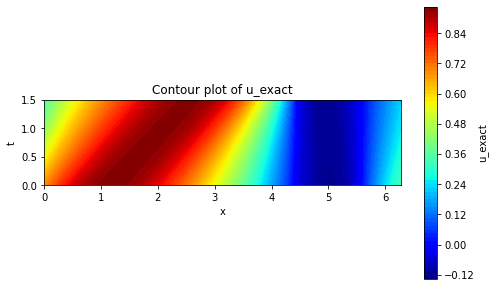

In [26]:
B_pinn.load()
xt = B_pinn.mesh.reshape(-1, 2)
xx, tt = xt[:, 0], xt[:, 1]
u_exact = B_pinn.u_exact.reshape(-1).detach().cpu().numpy()
u = B_pinn.model(torch.tensor(xt, dtype=torch.float32).to(device)).detach().cpu().numpy().flatten()
# 绘图
fig, ax = plt.subplots(figsize=(8, 5))
c = ax.tricontourf(xx, tt, u, levels=100, cmap='jet')
# c = ax.tricontourf(xx, tt, abs(u-u_exact), levels=100, cmap='jet')
plt.colorbar(c, ax=ax, label='u_exact')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Contour plot of u_exact')
ax.set_aspect('equal')
plt.show()

## test hpVPINN

In [29]:
class Burgers_hpVPINN:
    def __init__(self, N_x:int, N_t:int, Nint_x:int, deg:int, num_layers:int=2, hidden_size:int=20, act:str='tanh') -> None:
        #
        self.name = f'1dburgers_{N_x}_{N_t}_{Nint_x}_{deg}_{num_layers}_{hidden_size}_{act}'
        self.np_dtype = np.float64
        self.torch_dtype = torch.float64
        self.save_path = f'./models/DGNet/{self.name}.pth'
        #
        self.a = 0.0
        self.b = 2.0 * pi
        self.t0 = 0.0
        self.T = 1.5
        #
        self.N_x = N_x
        self.N_t = N_t
        self.Nint_x = Nint_x
        self.deg = deg
        #
        self.testfunc = TestFunction1D(func_type='Legendre')
        #
        self.x, self.xc, self.h, self.t, self.Mesh, self.xmesh, self.weights = self.get_mesh()
        mesh = self.Mesh.cpu().detach().numpy()
        self.v, self.dv = self.test_data()
        self.model = MLP(input_size=2, hidden_size=hidden_size, output_size=1, num_layers=num_layers, act=act).to(device).to(self.torch_dtype)
        #
        self.f = lambda x: x ** 2 / 2
        self.init = lambda x: torch.sin(x) + 1/2
        self.exact_init = self.init(self.xmesh)
        self.u_exact = torch.tensor(burgers_exact(mesh[:,:, :, 0], mesh[:,:, :, 1])).to(device)
        #
        self.Lfbgs = torch.optim.LBFGS(self.model.parameters(), lr=1.0, max_iter=40000, 
                                           max_eval=50000, history_size=50, tolerance_grad=1e-7, 
                                           tolerance_change=1.0 * np.finfo(float).eps, 
                                           line_search_fn='strong_wolfe')
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-4); self.maxiter = 100000; self.adamiter = 0
        self.iter = 0
      

    def test_data(self):
        v_list = []
        dv_list = []
        for i in range(self.deg + 1):
            v, dv = self.testfunc.get_value(x=self.xmesh, x_mid=self.xc[:, None], h=self.h[:, None], order=i)
            v_list.append(v)
            dv_list.append(dv)
        v = torch.stack(v_list, dim=0).to(device)
        dv = torch.stack(dv_list, dim=0).to(device)
        return v, dv
    
    def get_mesh(self):
        #
        x = np.linspace(self.a, self.b, self.N_x + 1)
        t = np.linspace(self.t0, self.T, self.N_t + 1)
        xc = (x[:-1] + x[1:]) / 2.0
        h = (x[1:] - x[:-1]) 
        nodes, weights = np.polynomial.legendre.leggauss(self.Nint_x)
        #
        mesh = 0.5 * (nodes[None, :] + 1) * h[:, None] + x[:-1, None]
        weights = 0.5 * weights[None, :] * h[:, None]
        xmesh = np.zeros((self.N_x, self.Nint_x + 2))
        xmesh[:, 1:-1] = mesh
        xmesh[:, 0] = x[:-1]
        xmesh[:, -1] = x[1:]
        Mesh = []
        for i in range(self.N_x):
            xx, tt = np.meshgrid(xmesh[i, :], t)
            Mesh.append(np.stack([xx, tt], axis=-1))
        Mesh = np.array(Mesh)
        return torch.tensor(x, dtype=self.torch_dtype).to(device), \
               torch.tensor(xc, dtype=self.torch_dtype).to(device), \
               torch.tensor(h, dtype=self.torch_dtype).to(device),\
               torch.tensor(t, dtype=self.torch_dtype).to(device),\
               torch.tensor(Mesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(xmesh, dtype=self.torch_dtype).to(device),\
               torch.tensor(weights, dtype=self.torch_dtype).to(device)

    
    def loss(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        fu = self.f(u)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux = gradu[..., 0]; ut = gradu[..., 1]
        #
        lfu = self.f(u[:, :, 0, 0]); rfu = self.f(u[:, :, -1, 0])
        lv = self.v[:, :, 0]; rv = self.v[:, :, -1]
        bd = rfu[None, ...] * rv[:, :, None] - lfu[None, ...] * lv[:, :, None]
        #
        lux = ux[0, :, 0]; rux = ux[-1, :, -1]
        ux = ux[:, :, 1:-1]; ut = ut[:, :, 1:-1]
        

        # compute local loss
        Int = torch.sum((ut[None, ...] * self.v[:, :, None, 1:-1] - fu[None, :, :, 1:-1, 0] * self.dv[:, :, None, 1:-1]) * self.weights[None, :, None, :], dim=-1) + bd
        local_loss = torch.sum(Int**2)
        # compute init_loss
        init_loss = torch.sum((u[:, 0, :, 0] - self.exact_init)**2)
        # compute bd_loss
        bd_loss = torch.sum((u[0, :, 0, 0] - u[-1, :, -1, 0])**2 + (rux - lux)**2)
        # compute flux_loss
        loss = local_loss + init_loss + bd_loss
        mse = torch.mean((u.squeeze(-1)-self.u_exact)**2)
        mae = torch.max(torch.abs(u.squeeze(-1)-self.u_exact))
        return loss, mse, mae

    def train(self):
        print('*********** Started training ...... ***************')
        t = time.time()
        self.writer = SummaryWriter(f'./logs/burgers1d/hpVPINN')
        loss, mse, mae = self.loss()
        best_loss = loss
        epoch = 0
        while  epoch < self.maxiter:
            self.Adam.zero_grad()
            loss, mse, mae = self.loss()
            self.writer.add_scalar(f"mse_vs_iter", mse, epoch)
            self.writer.add_scalar(f"mse_vs_time", mse, time.time() - t)
            loss.backward()
            self.Adam.step()
            epoch += 1
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), f'./models/hpVPINN/{self.name}.pth')
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}, mse = {mse.item():.6f}, mae = {mae.item():.6f}")
        self.writer.close()
        print(f'Finished training in {time.time()-t:.4f} seconds')
    def load(self):
        path = f'./models/hpVPINN/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train")
            return False
    

B = Burgers(N_x=3, N_t=30, Nint_x=30, deg=10, num_layers=2, hidden_size=50, act='tanh')
B.train()
# retrain = True
# if B.load() and not retrain:
#     print("train loss: ", B.loss())
# elif retrain:
#     B.load()
#     B.train()

/tmp/ipykernel_32151/1119745042.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  w_solution = fsolve(func, w0)
/tmp/ipykernel_32151/1119745042.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  w_solution = fsolve(func, w0)


*********** Started training ...... ***************
Epoch 100: Loss = 45.377558, mse = 0.483194, mae = 1.191757
Epoch 200: Loss = 38.837964, mse = 0.410642, mae = 1.048097
Epoch 300: Loss = 37.423193, mse = 0.391235, mae = 1.000650
Epoch 400: Loss = 36.338118, mse = 0.377983, mae = 1.003613
Epoch 500: Loss = 35.172337, mse = 0.364199, mae = 1.007239
Epoch 600: Loss = 33.775626, mse = 0.348750, mae = 1.008394
Epoch 700: Loss = 32.022364, mse = 0.330702, mae = 1.008569
Epoch 800: Loss = 29.864723, mse = 0.309637, mae = 1.007530
Epoch 900: Loss = 27.414478, mse = 0.286394, mae = 1.004823
Epoch 1000: Loss = 24.927518, mse = 0.262918, mae = 0.999397
Epoch 1100: Loss = 22.679921, mse = 0.241306, mae = 0.991020
Epoch 1200: Loss = 20.842261, mse = 0.222959, mae = 0.998268
Epoch 1300: Loss = 19.438601, mse = 0.208246, mae = 1.004569
Epoch 1400: Loss = 18.391560, mse = 0.196797, mae = 1.006605
Epoch 1500: Loss = 17.579344, mse = 0.187901, mae = 1.004029
Epoch 1600: Loss = 16.877565, mse = 0.1807

KeyboardInterrupt: 

Loading saved model...
(tensor(0.1083, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>), tensor(0.0043, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(1.3105, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>))


Text(0.5, 0, 'x')

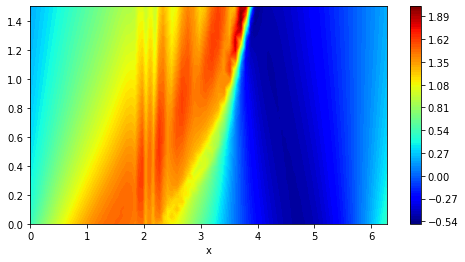

In [30]:
model = B.model
path = f'./models/DGNet/{B.name}.pth'
B.load()
print(B.loss())
xt = B.Mesh[:, :, :, :]
u = model(xt).squeeze(-1)

xt = xt.detach().cpu().numpy().reshape(-1, 2)
u = u.detach().cpu().numpy().flatten()

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
pic = ax.tricontourf(xt[:,0], xt[:,1], u, levels=100, cmap='jet')
fig.colorbar(pic, ax=ax)
# ax.set_aspect('equal')
ax.set_xlabel('x')


/tmp/ipykernel_32151/1119745042.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  w_solution = fsolve(func, w0)
/tmp/ipykernel_32151/1119745042.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  w_solution = fsolve(func, w0)


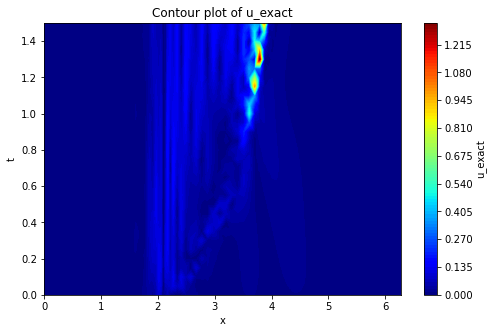

In [31]:
xt = B.Mesh[:, :, :, :].reshape(-1, 2)
xt = xt.detach().cpu().numpy()
xx, tt = xt[:, 0], xt[:, 1]
u_exact = burgers_exact(xx, tt)
u = u.reshape(-1)
# 绘图
fig, ax = plt.subplots(figsize=(8, 5))
# c = ax.contourf(xx, tt, u_exact, levels=100, cmap='jet')
c = ax.tricontourf(xx, tt, abs(u-u_exact), levels=100, cmap='jet')
plt.colorbar(c, ax=ax, label='u_exact')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Contour plot of u_exact')
# ax.set_aspect('equal')
plt.show()